1. Install Required Packages: The script begins by installing several Python packages using the pip package manager. These packages include langchain, langchain_ibm, ibm-watsonx-ai, and youtube-transcript-api.

In [1]:
!pip install langchain -q
!pip install langchain_ibm -q 
!pip install ibm-watsonx-ai -q
!pip install youtube-transcript-api -q

2. Create the credentials dictionary with the HTTPS endpoint to the Watson Machine Learning service  and the IBM Cloud API Key. Also set the Project ID. Cell hidden. Please see this:
https://community.ibm.com/community/user/blogs/ravi-bansal/2024/03/03/exploring-lengthy-youtube-video-summarization-with

In [2]:
# The code was removed by Watson Studio for sharing.

3. LangChain provides a YoutubeLoader class from the langchain_community.document_loaders module to load YouTube videos's transcript. The YouTube video's URL is provided as input. The loader to loads the Youtube video's transcript into Document objects. This only works with YouTube videos that have transcripts. Speech-to-Text can be used for videos missing a transcript.

In [3]:
from langchain_community.document_loaders import YoutubeLoader
loader = YoutubeLoader.from_youtube_url( "https://www.youtube.com/watch?v=txOv_pi-_R4", add_video_info=False)
list_of_doc_objects = loader.load()


4. Display the video:

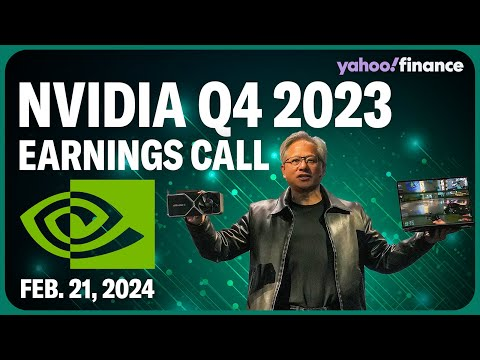

In [4]:
from IPython.display import YouTubeVideo

YouTubeVideo('txOv_pi-_R4', width=400, height=300)

5. Extract the text from the loaded Document object.

In [5]:

print("**** Number of document objects ****")
print(str(len(list_of_doc_objects)))


#print("**** Text of document ****")
text = list_of_doc_objects[0].page_content
#print(text)

**** Number of document objects ****
1


6. Analyze the text for number of characters and tokens. If the text is too long to fix in the context window (token limit), it will need splitting or chunking. 

In [6]:
words = text.split()
word_count = len(words)
print ("Number of words = " + str(word_count))
char_count = len(text)
print ("Number of characters = " + str(char_count))
num_tokens =    int (char_count/4)  # 4 chars per token
print ("Approx Number of tokens = " + str(num_tokens))





Number of words = 8429
Number of characters = 48711
Approx Number of tokens = 12177


7.  The text will be split into smaller chunks using the RecursiveCharacterTextSplitter class from the langchain.text_splitter module. This step is essential for processing large text efficiently. Text can be split in multiple ways such as by sentences, paragraphs etc. We want to split the text in such a way so that each chunk retains enough summarizable content without exceeding the token limit. Since we plan to use LLAMA_2_70B_CHAT model with a limit of 4k tokens, we will split the text for each chunk to be 2000 tokens or approximately 8000 characters. An overlap 800 characters enables maintaining context continuity between chunks when splitting text. We get 7 chunks.

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=8000, chunk_overlap=800)  #8000 characters or 2000 tokens
chunks = text_splitter.split_documents(list_of_doc_objects)
print("Number of Chunks: " + str(len(chunks)))


#for x in range (0, len(chunks)):
#    print("Chunk Number: "+str(x) +" " + chunks[x].page_content + "\n")   


Number of Chunks: 7


8. An instance of the wrapper IBM WatsonxLLM is initialized using the WatsonxLLM class from the langchain_ibm module. We set parameters for the AI model, specifying the decoding method, minimum and maximum number of new tokens, and stop sequences. The model ID, URL, API key, project ID, and parameters are provided as inputs. Please note that the instance of WatsonxLLM gives us a handle to the "LLAMA_2_70B_CHAT" foundation model so we can run inferences against it in the next step.

In [8]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes


#model parameters
parameters = {   
    GenParams.DECODING_METHOD: DecodingMethods.GREEDY,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.STOP_SEQUENCES: ["<|endoftext|>"]
}

from langchain_ibm import WatsonxLLM

model_id = ModelTypes.LLAMA_2_70B_CHAT  #LLM Model selected

llm = WatsonxLLM(
    model_id=model_id.value,
    url=credentials.get("url"),
    apikey=credentials.get("apikey"),
    project_id=project_id,
    params=parameters
)

9. Now we load a summarization chain using the load_summarize_chain function from the langchain.chains.summarize module. This chain is responsible for generating summaries based on the input text. The chain of the type "Map Reduce". Map-Reduce works by first "mapping" each document or document chunk to an individual summary. This is guided by the "map_prompt" and is done using a separate LLM call for each document or text chunk. Once all of the individual summaries have been generated, they are then reduced to combine them into a single global summary. This is guided by the "combine_prompt" and is also done using a separate LLM call.

In [9]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate



map_prompt = "Write a concise summary of the following:'{text}' CONCISE SUMMARY: "
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

combine_prompt = "Write a concise abstractive summary of the following:'{text}' Summary should include financial numbers."
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
                                     verbose=False
                                    )                                   

10. Finally we invoke the summarization chain on the text chunks obtained earlier. The generated summary is printed to the console. The summary is less than 300 words

In [10]:
LLM_response = summary_chain.invoke(chunks)
print(LLM_response.get("output_text"))



NVIDIA's Q4 earnings call highlighted the company's record-breaking revenue of $22.1 billion, up 22% sequentially and 265% year-over-year, driven by strong demand for its data center and professional visualization products. Data center revenue reached a record $18.4 billion, up 27% sequentially and 49% year-over-year, while professional visualization revenue increased 11% sequentially and 105% year-over-year. The company's gross margins expanded to 76%, and non-GAAP gross margins reached 76.7%. NVIDIA's Q1 guidance indicates total revenue of $24 billion, plus or minus 2%, with growth in data center and professional visualization partially offset by a seasonal decline in gaming. The company expects gross margins to return to the mid-70s range beyond Q1.

During the call, NVIDIA CEO Jensen Huang and CFO Colette Kress discussed the company's success in software, which has grown to over a billion dollars, with the majority coming from its accelerated computing and AI business. They also 

11. We can try different foundation models and vary chunk sizes and prompts to get the best results. The selection of values for these may be dynamically calculated based on the characteristics such as the length and format of input text. As an example, please see a different output obtained by modifying the prompt.

In [11]:
map_prompt = "Write a concise summary of the following:'{text}' CONCISE SUMMARY: "
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

combine_prompt = "Write a concise bullet point summary of the following:'{text}'. The summary should include financial numbers."
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
                                     verbose=False
                                    )                               

12. Bulleted summary generated as per the modified input prompt.

In [12]:
LLM_response = summary_chain.invoke(chunks)
print(LLM_response.get("output_text"))



* NVIDIA's Q4 revenue was $22.1 billion, up 22% sequentially and 265% year-over-year.
* Data center revenue was $18.4 billion, a record, up 27% sequentially and 49% year-over-year.
* Demand for Hopper remains strong, but supply is limited.
* The company's computing stack seamlessly extends across cloud and on-premise environments.
* Large cloud providers represented more than half of data center revenue.
* Consumer internet companies have been early adopters of AI, and enterprise software companies are applying generative AI to help customers realize productivity gains.
* NVIDIA collaborated with Google to optimize its state-of-the-art new Gemma language models to accelerate their inference performance on NVIDIA GPUs in the cloud and data center.
* Adoption of AI by enterprises across industry verticals such as automotive, healthcare, and financial services is a notable trend.
* NVIDIA offers multiple application frameworks to help companies adopt AI in vertical domains.
* Gaming rev